In [1]:
# 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 2. Load and Merge Data
customers = pd.read_csv("/content/Customers.csv")
transactions = pd.read_csv("/content/Transactions.csv")

In [3]:
# Merge data
merged_data = transactions.groupby("CustomerID").agg(
    TotalSpend=("TotalValue", "sum"),
    AvgOrderValue=("TotalValue", "mean"),
    NumTransactions=("TransactionID", "count")
).reset_index()
merged_data = pd.merge(merged_data, customers, on="CustomerID", how="left")

# One-hot encode 'Region'
merged_data = pd.get_dummies(merged_data, columns=["Region"])

In [4]:
# 3. Preprocessing
# ======================
# Select relevant features
features = ["TotalSpend", "AvgOrderValue", "NumTransactions"] + list(merged_data.filter(like="Region").columns)
X = merged_data[features]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

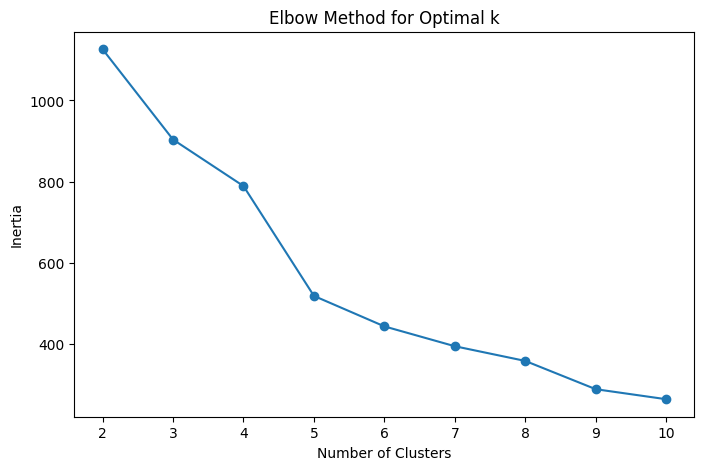

In [5]:
# 4. Clustering with K-Means
# Determine optimal clusters (Elbow Method)
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

In [6]:
# Fit K-Means with optimal k
optimal_k = 4  # Example: Pick from Elbow Curve
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
merged_data["Cluster"] = kmeans.fit_predict(X_scaled)

In [7]:
# 5. Evaluate Clustering
db_index = davies_bouldin_score(X_scaled, merged_data["Cluster"])
sil_score = silhouette_score(X_scaled, merged_data["Cluster"])

print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {sil_score}")

Davies-Bouldin Index: 1.23651322461426
Silhouette Score: 0.2887737637391407


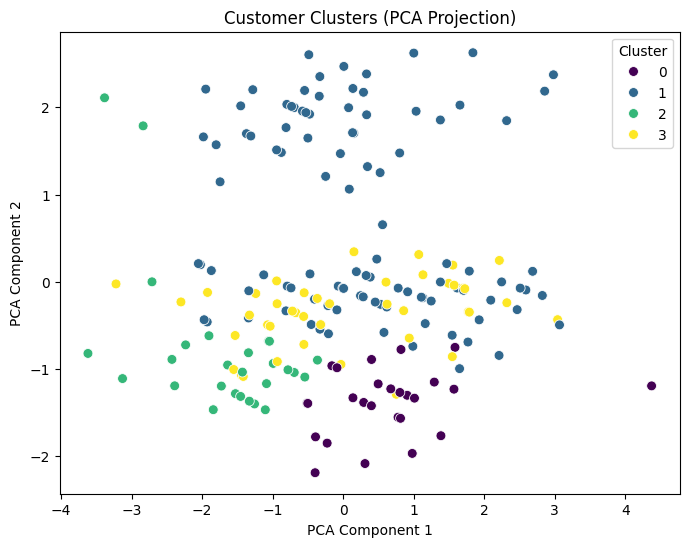

In [8]:
# 6. Visualize Clusters
# Visualize clusters in 2D space (using first 2 PCA components for simplicity)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=merged_data["Cluster"], palette="viridis", s=50)
plt.title("Customer Clusters (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()


In [9]:
# 7. Save Results
merged_data[["CustomerID", "Cluster"]].to_csv("Customer_Clusters.csv", index=False)